In [1]:
import numpy as np
import emcee as em
import pandas as pd

#import sys
#sys.path.append("/home/agath/anaconda3/envs/JetFit/lib/python3.12/site-packages/afterglowpy/")
import afterglowpy as grb

import subprocess
import os
import sys

current_directory = os.getcwd()
jetfitcode_path = os.path.join(current_directory, 'jetfitcode')
sys.path.append(jetfitcode_path)

from FitterClass import *
from FluxGeneratorClass import *
from collections import defaultdict

import matplotlib.pyplot as plt #For plotting

#import jetsimpy

In [2]:
#Importing the precomputed fluxes to put in the JetFit functions
Table = os.path.join(jetfitcode_path, 'Table.h5') 

#Importing the files from BOXFIT
settings = '/home/agath/boxfitoutput/boxfitsettings.txt'
lightcurve_box = '/home/agath/boxfitoutput/lightcurve.txt'
spectrum_box = '/home/agath/boxfitoutput/spectrum.txt'

#Data from GW170817
gw = '/home/agath/boxfitoutput/GW170817_3GHz_VLAobs.txt'

### Boxfit

To import the input parameters, and keep them for the rest of the code, and get the output values of BoxFit

In [3]:
def read_boxfit(settings): #Read the parameters from boxfit and apply them to afterglowpy and maybe jetfit
    B = {} #Declare an empty dictionary
    with open(settings,'r') as f:
        for line in f:
            #Check if line is not an overall comment and has an equal and a comment to describe the parameter
            if not line.strip().startswith('!') and '=' in line and '!' in line: 
                keyval_extra = line.strip().split('!') #Split the key + value from the comment using the !
                key_value = keyval_extra[0].split('=') #Split the key from the value using the = 
                key, value = key_value[0].strip(), key_value[1].strip() #Store them
                
                #If the value is a number, store it in B, and convert it from a str to a float
                if value.isdigit() or 'e-' in value or 'e' in value or '.' in value:
                    if not '.txt' in value: #Because simplex and grbdata could get past this point
                        B[key] = float(value) 
    return B

In [4]:
B = read_boxfit(settings)

In [5]:
#Parameters common to all three models
t_min = B['t_0']
t_max = B['t_1'] 

nu_min = B['nu_0']
nu_max = B['nu_1']

points = int(B['no_points'])

In [6]:
#The corresponding linspaces
tl = np.geomspace(t_min, t_max, points)
nus = np.geomspace(nu_min, nu_max, points)

nul = np.ones(nus.shape)*nu_min
ts = np.ones(tl.shape)*t_min

In [7]:
#Initialize the lists for Boxfit
tbox =  []
nubox =  []
Flbox =  []
Fnubox =  []

def read_data_box(f, lightcurve = True): #lightcurve = true when getting the lightcurve data, = false for the spectrum
    #Dummy index
    i = 0

    #Loop on the line
    for line in f:

        #Ignore line if it's a comment
        if line.startswith('#'):
            i = i + 1
            continue  # The loop restarts
    
        #Split line into columns and remove the commas
        columns = line.strip().replace(',','').split()  

        #Add data to lists        
        if lightcurve == True:
            tbox.append(float(columns[1]))
            Flbox.append(float(columns[3]))
        else:
            nubox.append(float(columns[2]))
            Fnubox.append(float(columns[3]))
            
        

# To read the data from Boxfit and plot it 
with open(lightcurve_box, 'r') as f1, open(spectrum_box, 'r') as f2:
    read_data_box(f1, lightcurve=True)
    read_data_box(f2,lightcurve=False)

# Convert lists to arrays
tbox = np.array(tbox) #Just here to make sure it's the same as the linspace, same for nu
nubox = np.array(nubox)
Fnubox = np.array(Fnubox)
Flbox = np.array(Flbox)


In [8]:
#print('be',B['E'],'je',J['E'],'log10je',np.log(J['E']),'10**jE',10**J['E'],'Ae',A['E0'])
#print('bn',B['n'],'jn',J['n'],'log10jn',np.log(J['n']),'10**jn',10**J['n'],'an',A['n0'])

### Small useful functions 

In [9]:
#Converts E to Eiso
def convert_E_Eiso(E,theta):
    #Theta being the half opening angle of the jet
    Eiso = E/(1-np.cos(theta)) #
    return Eiso 

In [10]:
#Converts Eiso to E
def convert_Eiso_E(Eiso,theta):
    #Theta being the half opening angle of the jet
    E = Eiso*(1-np.cos(theta)) #
    return E 

In [11]:
# convert_Eiso_E(8.2e53,B['theta_0'])

In [12]:
#Converts time in s to time in days
def convert_ts_td(t):
    return t/(60*60*24)

In [13]:
# print(convert_E_Eiso(2.5e50,B['theta_0']))

### Afterglowpy

In [14]:
#Afterglowpy dictionary contining the specifics of the jet and environment parameters
A = {'jetType':     grb.jet.TopHat,     # Top-Hat jet
     'specType':    0,                  # Basic Synchrotron Spectrum
     'thetaWing':   B['theta_obs'],  # Outer truncation angle
     'thetaObs':    B['theta_obs'],   # Viewing angle in radians, (roughly 20 degrees)
     'E0':          B['E'], # Isotropic-equivalent energy in erg
     'thetaCore':   B['theta_0'],    # Half-opening angle in radians
     'n0':          B['n'],    # circumburst density in cm^{-3}
     'p':           B['p'],    # electron energy distribution index
     'epsilon_e':   B['epsilon_E'],    # epsilon_e
     'epsilon_B':   B['epsilon_B'],   # epsilon_B
     'xi_N':        B['ksi_N'],    # Fraction of electrons accelerated
     'd_L':         B['d_L'], # Luminosity distance in cm (40Mpc)
     'z':           B['z'],   # redshift
     'b':           4.5}  #power for power-law structure theta**(-b)



In [15]:
def light_curve_afterglowpy(A):
    # Calculate the flux for both
    Fnula = grb.fluxDensity(tl, nul, **A)
    Fnusa = grb.fluxDensity(ts, nus, **A)

    return Fnula, Fnusa

Fnula, Fnusa = light_curve_afterglowpy(A)

In [16]:
#Get multiple geometries from Afterglowpy
types_jets = [grb.jet.TopHat, grb.jet.Gaussian, grb.jet.GaussianCore, grb.jet.PowerLaw, grb.jet.PowerLawCore]
name_types_jets = ['TopHat', 'Gaussian', 'GaussianCore', 'PowerLaw', 'PowerLawCore']

afterglowpys = [light_curve_afterglowpy(A) for A['jetType'] in types_jets]

#print(np.shape(afterglowpys))

### DeepGlow

In [17]:
#Insert here the training code for DeepGlow

In [18]:
# #For DeepGlow
# model = Emulator(simtype='ism')

# abs_factor = (B['p'] - 2)/(B['p'] - 1)

# deep_array = [B['z'],           #redshift
#               np.log10(B['d_L']/10**28),    #luminosity distance (log10 of 10^28 cm)
#               np.log10(B['E']/10**53),    #isotropic-equivalent energy (log10 of 10^53 erg)
#               np.log10(B['n']),     #circumburst medium density (log10 of cm^-3)
#               B['theta_0'],    #jet half-opening angle (rad)
#               B['theta_obs']/B['theta_0'],   #off-axis observer angle as a fraction of the jet half-opening angle
#               B['p'],    #electron spectral index
#               np.log10(B['epsilon_E']*abs_factor),   # energy fraction in accelerated electrons (in log10), with factor of (p-2)/p-1 absorbed
#               np.log10(B['epsilon_B']),  #energy fraction in magnetic field (in log10)
#               np.log10(B['ksi_N'])  #fraction of electrons accelerated (in log10)
#               ]

# Fldeep = model.flux(params=deep_array, t_obs=tl, nu_obs=nul)


### JetSimpy

In [19]:
import jetsimpy

In [20]:


# jet1 = jetsimpy.Afterglow(
#     B['theta_0'],           # array of theta
#     B['E'],            # array of isotropic equivalent energy
#     300,              # array of initial lorentz factor
#     0,          # scale of wind density
#     B["n0"],         # constant number density
#     spread=False,    # (default = True) with/without spreading effect 
#     coast=True,      # (default = True) with/without coasting. If this is "False", the initial lorentz factor data will be omitted.
# )

### JetFit

In [21]:
#JetFit informations
Info = {
    'Fit': np.array(['E', 'Eta0', 'GammaB','theta_obs','epsb','epse','n','p','z','xiN','dL','theta_obs']),         # Fitting parameters (Parameter names see P dictionary below)
    'Log': np.array([]),        # Set parameters in log scale 'E','n','epse','epsb' (mesured in log for mcmc analysis)
    'LogType': 'Log10',                              # Log scale type: Log10 or Log
    'ThetaObsPrior': 'Sine',                         # Prior for observation angle: Sine or Uniform
    'FluxType': 'Spectral'                           # Flux type: Spectral or Integrated
}

#JetFit bounds for parameters in linear scale
FitBound = {
    'E': np.array([1e-6, 1e3]),
    'n': np.array([1e-6, 1e3]),
    'Eta0': np.array([2.,10.]),
    'GammaB': np.array([1.,12.]),
    'theta_obs': np.array([0.,1.]),
    'epse': np.array([1e-6,1.]),
    'epsb': np.array([1e-6,1.]),
    'p': np.array([2.,4.])
}

#JetFit dict
Explore = False # For non-fiting parameters, P set default values. 

J = {
    'E': convert_Eiso_E(B['E'],B['theta_0'])/10**50, #E/10^50 convert_Eiso_E(B['E'],B['theta_0'])
    'Eta0': 8,
    'GammaB': 12,
    'dL': B['d_L']/10**28, #dl/10^28 cm
    'epsb': 7e-6, #B['epsilon_B']
    'epse': B['epsilon_E'],
    'n': B['n'], #np/1 cm-3
    'p': B['p'],
    'theta_obs': B['theta_obs'],
    'xiN': B['ksi_N'],
    'z': B['z']
}


In [22]:
print(B['E'])

1.0208249320351635e+53


In [23]:
print(convert_Eiso_E(B['E'],B['theta_0'])/10**50)

2.4866803585502892


In [37]:
print(J)

{'E': 2.4866803585502892, 'Eta0': 8, 'GammaB': 12, 'theta_obs': 0.44, 'epsb': 7e-06, 'epse': 0.1, 'n': 0.01, 'p': 2.15, 'z': 0.00973, 'xiN': 1.0, 'dL': 0.012}


In [24]:
#Calculates the range for time with respect to the bounds of tau for jetfit

def range_time_tau():
    #print('jn',J['n'],'je',J['E'],'jz',J['z'],'tmin',t_min,'tmax',t_max)

    #The range and formula from the paper
    tau_min = 8.64e2
    tau_max = 8.64e7
    scale = (1. + J['z'])*(J['E']/J['n'])**(1./3.)
    ti = tau_min*scale
    tf = tau_max*scale

    print('The time range allowed by tau is: [',"{:e}".format(ti),',',"{:e}".format(tf),']')

    if t_min < ti:
        print('The lower boundary is out of bounds:', "{:e}".format(t_min), 'is lower than', "{:e}".format(ti))
    elif t_max > tf:
        print('The upper boundary is out of bounds:', "{:e}".format(t_max),'is higher than', "{:e}".format(tf))
    else:
        print('The values are within the time range')
    return ti, tf

In [25]:
#For JetFit
def Log2Linear(Log, Info):
    Linear = {} #Defined as a dictionary
    for i, key in enumerate(Info['Fit']): #Going through all the parameters
        if key in Info['Log']:  #If it is in logscale, then use the exponential or 10^X
            if Info['LogType'] == 'Log10':
                Linear[key] = np.power(10.,Log[key])
            else:
                Linear[key] = np.exp(Log[key])
        else:
            Linear[key] = Log[key]
    # print(Linear['E'],Linear) #Debug statement to see the full dict
    return Linear


In [26]:
def light_curve_jetfit(P):

    ti, tf = range_time_tau()
    #print(FluxGenerator.Axes[0])

    #Calculate flux
    flux_jet = np.asarray(FluxGenerator.GetSpectral(tl, nul, P))
    print('flux', flux_jet)

    return flux_jet

In [27]:
#Transform the log variables from the P dictionnary to linear ones
J = Log2Linear(J,Info) 

#Create FluxGeneratorClass based on the given table
FluxGenerator = FluxGeneratorClass(Table)

#Get the lightcurve from the function
Fljet = light_curve_jetfit(J)

The time range allowed by tau is: [ 5.486040e+03 , 5.486040e+08 ]
The values are within the time range
flux [0.00013946 0.0001785  0.00022695 0.00028714 0.00036329 0.00045964
 0.00056372 0.00068905 0.00084223 0.00102119 0.00120428 0.0014202
 0.00167483 0.00197354 0.002324   0.0027367  0.00322268 0.00376093
 0.00438321 0.00510846 0.00590766 0.00661473 0.00740644 0.0082929
 0.00922243 0.010191   0.01126129 0.01244399 0.01353657 0.01468095
 0.01592207 0.01721705 0.01833526 0.01952609 0.02079426 0.02215298
 0.02360971 0.02516224 0.02681685 0.02843872 0.03012317 0.03190739
 0.03377946 0.0356365  0.03759563 0.03966246 0.04168351 0.04360694
 0.04561912 0.04772415 0.05047675 0.05355647 0.05682409 0.06019989
 0.06291146 0.06574517 0.06870651 0.07204352 0.07589098 0.0799439
 0.08421327 0.08863292 0.09325662 0.09812152 0.10290755 0.1032903
 0.10367448 0.10406008 0.10341592 0.10120195 0.09903538 0.09691519
 0.08832918 0.07824518 0.06931241 0.06135666 0.05334099 0.04637249
 0.04031436 0.03472163 0.

In [38]:
print(tl, nul)

[  170000.           181217.09772986   193174.33240961   205920.5404422
   219507.78059941   233991.54664323   249430.99397651   265889.18124881
   283433.327904     302135.08872164   322070.84647347   343322.02389013
   365975.41621242   390123.54568525   415865.03944215   443305.03232365
   472555.59627491   503736.19807614   536974.18727548   572405.31631715
   610174.29498904   650435.38145458   693353.01228244   739102.47404753
   787870.61924621   839856.62944957   895272.82881197   954345.55125711
  1017316.06488364  1084441.55736575  1155996.18637337  1232272.19930218
  1313581.12688667  1400255.05557132  1492647.98383648  1591137.26801869
  1696125.1635304   1808040.46777392  1927340.2714596   2054511.82548113
  2190074.53097278  2334582.06067632  2488624.62028214  2652831.35898005
  2827872.93906548  3014464.27509565  3213367.45378345  3425394.84655431
  3651412.42747881  3892343.31013212  4149171.5178258   4422946.00261058
  4714784.92946462  5025880.24316511  5357502.536495

In [28]:
def get_integrated_jetfit(P):

    #The function takes as an input an array with two columns, so we split the data into two arrays with points (because points/2 fails)
    mid_point = nus[int(points/2)]
    nus_col = np.column_stack((np.geomspace(nu_min, mid_point, points), np.geomspace(mid_point, nu_max, points)))
    
    #print('time', time)
    #Calculate flux
    Fsjet = np.asarray(FluxGenerator.GetIntegratedFlux(ts, nus_col, P))
    print(Fsjet)

    return nus_col, Fsjet

nusj, Fsjet = get_integrated_jetfit(J)

[2.91779343e-18 3.08699890e-18 3.26601673e-18 3.45541594e-18
 3.65579858e-18 3.86780156e-18 4.09209876e-18 4.32940313e-18
 4.58046897e-18 4.84609431e-18 5.12712348e-18 5.42444974e-18
 5.73901817e-18 6.07182868e-18 6.42393911e-18 6.79646869e-18
 7.19060154e-18 7.60759044e-18 8.04876084e-18 8.51551503e-18
 9.00933663e-18 9.53179531e-18 1.00845517e-17 1.06693629e-17
 1.12880877e-17 1.19426927e-17 1.26352588e-17 1.33679873e-17
 1.41432071e-17 1.49633825e-17 1.58311205e-17 1.67491791e-17
 1.77204765e-17 1.87481002e-17 1.98353164e-17 2.09855810e-17
 2.22025502e-17 2.34900922e-17 2.48522995e-17 2.62935022e-17
 2.78182810e-17 2.94314828e-17 3.11382351e-17 3.29439630e-17
 3.48544062e-17 3.68756371e-17 3.90140804e-17 4.12765333e-17
 4.36701872e-17 4.62026504e-17 4.88819727e-17 5.17166703e-17
 5.47157537e-17 5.78887556e-17 6.12457616e-17 6.47974422e-17
 6.85550868e-17 7.25306392e-17 7.67367359e-17 8.11867465e-17
 8.58948155e-17 9.08759078e-17 9.61458562e-17 1.01721412e-16
 1.07620296e-16 1.138612

### Get the data points from GW170817

In [29]:
#Declare lists for the variables
t_gw = []
nu_gw = []
Fl_gw = []
Flerr_gw = []

with open(gw,'r') as file:

    for line in file:
        #Ignore the comments
        if line.startswith('#'): 
            continue
        
        #Split line into columns and remove the spaces
        columns = line.strip().split()  

        t_gw.append(float(columns[0]))
        Fl_gw.append(float(columns[1]))
        Flerr_gw.append(float(columns[2]))
        nu_gw.append(float(columns[3]))

# Convert lists to arrays
t_gw = np.array(t_gw) #Contrary to the others, the time is in days
Fl_gw = np.array(Fl_gw)
Flerr_gw = np.array(Flerr_gw)
nu_gw = np.array(nu_gw)        

In [30]:
print(B['epsilon_B'])

7e-06


In [31]:
print(Fl_gw,nu_gw)

[0.0187 0.0151 0.0145 0.0225 0.0256 0.034  0.044  0.048  0.061  0.07
 0.103  0.098  0.073  0.069  0.0647 0.055  0.0403 0.0439 0.0464 0.0312
 0.0148 0.005 ] [3.e+09 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09
 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09 3.e+09
 3.e+09 3.e+09]


## Plot the Lightcurves and Spectra

/tmp/ipykernel_56536/4194358729.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/tmp/ipykernel_56536/4194358729.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


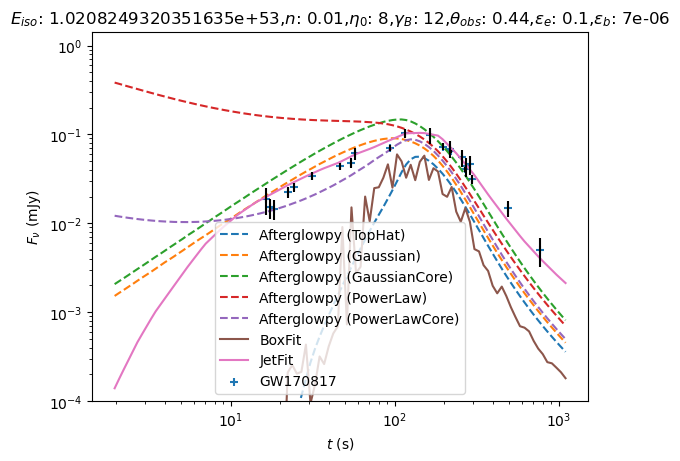

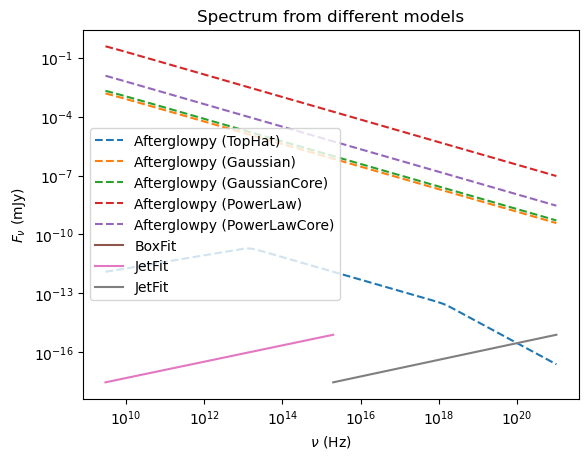

In [32]:
#To get a Label
Label = {
    r'$E_{iso}$': B['E'],
    r'$n$': B['n'],
    r'$\eta_0$': J['Eta0'],
    r'$\gamma_B$': J['GammaB'],
    r'$\theta_{obs}$': B['theta_obs'],
    r'$\epsilon_e$': B['epsilon_E'],
    r'$\epsilon_b$': B['epsilon_B']
}

labels = ["{}: {}".format(key, value) for key, value in Label.items()]


#For Plotting the lightcurve and spectrum of Afterglowpy and Boxfit
fig1, ax1 = plt.subplots(1, 1)
[ax1.plot(convert_ts_td(tl), afterglowpys[i][0], label= f"Afterglowpy ({name_types_jets[i]})", linestyle='dashed') for i in range(len(afterglowpys))] #convert_ts_td(tl)
#ax1.plot(convert_ts_td(tl), Fnula, label="Afterglowpy") #convert_ts_td(tl)
ax1.plot(convert_ts_td(tbox), Flbox, label="BoxFit") #convert_ts_td(tbox)
ax1.plot(convert_ts_td(tl), Fljet, label="JetFit") #convert_ts_td(tlj) Fljet*1e-6
ax1.scatter(t_gw, Fl_gw, label = "GW170817", marker = '+')
ax1.errorbar(t_gw, Fl_gw,yerr=Flerr_gw,linestyle='', color='black')
#ax1.plot(convert_ts_td(tl), Fldeep , label="DeepGlow")
ax1.set_title("{}".format(",".join(labels)))
ax1.set(xscale='log', xlabel=r'$t$ (s)',
       yscale='log', ylabel=r'$F_\nu$ (mJy)')
ax1.legend()
ax1.set_ylim(10**-4,)
fig1.savefig("lightcurve_comp.png")

fig2, ax2 = plt.subplots(1, 1)
[ax2.plot(nus, afterglowpys[i][1], label= f"Afterglowpy ({name_types_jets[i]})", linestyle='dashed') for i in range(len(afterglowpys))] #convert_ts_td(tl)
#ax2.plot(nus, Fnusa, label="Afterglowpy")
ax2.plot(nus, Fnubox, label="BoxFit")
ax2.plot(nusj, Fsjet, label="JetFit")
ax2.set_title("Spectrum from different models")
ax2.set(xscale='log', xlabel=r'$\nu$ (Hz)',
       yscale='log', ylabel=r'$F_\nu$ (mJy)')
ax2.legend()
fig2.savefig("spectrum_comp.png")

fig1.show()
fig2.show()

In [33]:
def time_flux_peaks(Fnu, t):
    
    Fnu_peak = np.max(Fnu)
    t_peak = t[np.argmax(Fnu)]

    return Fnu_peak, t_peak

In [34]:
import random

print(np.random.uniform(1,10))
#Rescaling as in Nakar

def rescaling( theta_obs, theta_0,E, n, epse, nu, d_L,p, Fl, t, ): #maybe change this with **kwargs but beware that not all dictionnaries have the same key name for the same physical variable (or the same scale, check jetfit)

    #Get the old ratio, should be constrained between 10 and 3
    ratio = theta_obs/theta_0
    print('The ratio is', ratio)

    #Get the new angle values with the same ratio, theta_obs contrained between 0 and 1.57, theta_0 between 0.045 and 0.5, wrote a statement in case out of bounds
    theta_obs_re = np.random.uniform(0.045*ratio,1.57)
    theta_0_re = theta_obs_re/ratio

    if theta_0_re > 0.5 or theta_0_re < 0.045:
        print('Random theta j out of bounds for this ratio and theta obs', theta_0_re)

    #Get the previous t_peak and f_peak
    Fl_peak, t_peak = time_flux_peaks(Fl, t)

    #Get the new t_peak and F_peak
    n_re = (((theta_obs_re - theta_0_re)**2*E**(1/3))/t_peak)**(1/3)
    epsb_re = ((Fl_peak)/E*(n**(p+1/4))*(epse**(p-1))*(theta_obs**(-2*p))*(nu**(-(p-1)/2))*(d_L**-2))**(4/p+1)

    #Calculate the 
    return theta_obs_re, theta_0_re, epsb_re, n_re

3.5921013390500116


In [35]:
rescaling(B['theta_obs'], B['theta_0'], B['E'], B['n'], B['epsilon_E'], nus[0], B['d_L'], B['p'], Flbox, tbox)

The ratio is 6.302533045326672


(1.4154677275209395, 0.22458711717037466, 0.0, 4202.175311992503)

In [36]:
print(B['theta_obs'], B['theta_0'], B['E'], B['n'], B['epsilon_E'], nus[0], B['d_L'], B['p'], Flbox, tbox)

0.44 0.0698132 1.0208249320351635e+53 0.01 0.1 3000000000.0 1.2e+26 2.15 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 1.514814e-07 5.788921e-07 3.179579e-07 1.605276e-06
 1.146922e-06 1.009551e-06 1.345201e-06 3.443389e-06 4.166948e-06
 5.654103e-06 6.742736e-06 9.847781e-06 2.094393e-04 2.552282e-04
 2.037469e-04 2.132972e-04 4.321848e-04 9.433319e-05 1.537710e-04
 3.178266e-04 2.610757e-04 4.121081e-04 5.768680e-04 6.926996e-04
 9.077013e-03 7.291952e-04 1.510852e-02 2.759316e-03 3.246507e-03
 1.998786e-02 1.053599e-02 2.487351e-02 2.544006e-02 3.255536e-02
 4.605091e-02 2.518185e-02 5.959249e-02 4.972027e-02 3.256786e-02
 4.553438e-02 3.057072e-02 4.911814e-02 5.767249e-02 3.074812e-02
 4.

This table indicates the input of each model as well as the units

| Input Parameter | BoxFit | Afterglowpy | JetFit | JetSimpy |
|:--------:|:--------:|:--------:| :--------:| :--------:|
|  $\theta_{obs}$   |  Row 1   |  Row 1   | Row 1   | Row 1   |
|  $\theta_{j}$    |  Row 2   |  Row 2   | Row 1   | Row 1   |
|  $\theta_{wing}$    |  Row 2   |  Row 2   | Row 1   | Row 1   |
|  $n$    |  Row 2   |  Row 2   | Row 1   | Row 1   |
|  $p$    |  Row 2   |  Row 2   | Row 1   | Row 1   |
|  $E$   |  Row 3   |  Row 3   | Row 1   | Row 1   |
|  $E_{iso}$   |  Row 3   |  Row 3   | Row 1   | Row 1   |
|  $\eta_0$   |  Row 3   |  Row 3   | Row 1   | Row 1   |
|  $\gamma_B$   |  Row 3   |  Row 3   | Row 1   | Row 1   |
|  $\epsilon_B$   |  Row 3   |  Row 3   | Row 1   | Row 1   |
|  $\epsilon_E$   |  Row 3   |  Row 3   | Row 1   | Row 1   |
|  $\xi_N$   |  Row 3   |  Row 3   | Row 1   | Row 1   |
|  $d_L$   |  Row 3   |  Row 3   | Row 1   | Row 1   |
|  $z$   |  Row 3   |  Row 3   | Row 1   | Row 1   |
|  $b$   |  Row 3   |  Row 3   | Row 1   | Row 1   |

In [39]:
# #Theta Linspace
# theta = np.linspace(0, np.pi, 1000) 

# #Constructing the Eiso linspace
# theta_c = D['theta_0']
# b = A['b']
# E_0 = 1.0208249320351635e+53
# gb = D['GammaB']
# e0 = D['Eta0']

# # Top Hat np.heaviside(-thetalinsp+theta_c,thetalinsp[999]- theta_c)
# Eiso_th = E_0*np.heaviside(-theta+theta_c,theta[999]-theta_c) # Using the heaviside funcion that is 0 for x < 0 and 1 for x > 1 with x running from 1 to -9 to get only a small potion that is = 1 with sharp edges

# # Gaussian
# Eiso_g = E_0*np.exp(-0.5*(theta/theta_c)**2) 

# # Power-Law
# Eiso_pl = E_0*( 1 + (1/b)*(theta/theta_c)**2 )**(-b/2)

# # Boosted Fireball
# v0 = np.sqrt(1 - 1/e0**2)
# vb = np.sqrt(1 - 1/gb**2) 
# sin_fact = gb*vb*np.sin(theta) #convert_deg_to_rad(thetalinsp)
# gamma_max_0 = gb*(e0 + vb*e0*v0)
# gamma_max = gb*(e0 + vb*np.cos(theta))*np.sqrt((e0*v0)**2 - sin_fact**2)/(1 + sin_fact**2)
# #Eiso = (E_0/4*np.pi)*(gamma_max/gamma_max_0)**3

# #Eiso = B["E"] * np.exp(- 0.5 * (theta / B["theta_0"]) ** 2)

# # Lorentz fator
# lf = (calc_lf(D['Eta0'], D['GammaB']) - 1) * np.exp(- 0.5 * (theta / D["theta_0"]) ** 2) + 1

### Attempt to verify that only the ratio $\theta_{obs}$/$\theta_j$ is constrained

In [ ]:
def time_flux_peaks(Fnu, t):
    
    Fnu_peak = np.max(Fnu)
    t_peak = t[np.argmax(Fnu)]

    return Fnu_peak, t_peak
import random

print(np.random.uniform(1,10))
#Rescaling as in Nakar

def rescaling( theta_obs, theta_0,E, n, epse, nu, d_L,p, Fl, t, ): #maybe change this with **kwargs but beware that not all dictionnaries have the same key name for the same physical variable (or the same scale, check jetfit)

    #Get the old ratio, should be constrained between 10 and 3
    ratio = theta_obs/theta_0
    print('The ratio is', ratio)

    #Get the new angle values with the same ratio, theta_obs contrained between 0 and 1.57, theta_0 between 0.045 and 0.5, wrote a statement in case out of bounds
    theta_obs_re = np.random.uniform(0.045*ratio,1.57)
    theta_0_re = theta_obs_re/ratio

    if theta_0_re > 0.5 or theta_0_re < 0.045:
        print('Random theta j out of bounds for this ratio and theta obs', theta_0_re)

    #Get the previous t_peak and f_peak
    Fl_peak, t_peak = time_flux_peaks(Fl, t)

    #Get the new t_peak and F_peak
    n_re = (((theta_obs_re - theta_0_re)**2*E**(1/3))/t_peak)**(1/3)
    epsb_re = ((Fl_peak)/E*(n**(p+1/4))*(epse**(p-1))*(theta_obs**(-2*p))*(nu**(-(p-1)/2))*(d_L**-2))**(4/p+1)

    #Calculate the 
    return theta_obs_re, theta_0_re, epsb_re, n_re
rescaling(D['theta_obs'], D['theta_0'], D['E'], D['n'], D['epsilon_E'], freqs[0], D['d_L'], D['p'], Fl_box, time_box)

In [ ]:
# Function to calculate the flux with JetFit for spectra
def get_integrated_jetfit(P): 

    # The function takes as an input an array with two columns, so splitting the data into two arrays with points (because points/2 fails)
    mid_point = freqs[int(points/2)]
    nus_col   = np.column_stack((np.geomspace(nu_min, mid_point, points), np.geomspace(mid_point, nu_max, points)))
    
    Fsjet = np.asarray(FluxGenerator.GetIntegratedFlux(time, nus_col, P))

    return nus_col, Fsjet